# spiel:

this is a notebook for testing the use of normalization wrappers, specifically carrying two `envs`: one of which is wrapped using a `NormalizeObservation` wrapper, and the other is just a raw `env`. the purpose of doing this is so that the raw transitions are sent to the buffer, such that they can be normalized with fresh statistics instead of stale ones

# import

In [1]:
# import these:
import gymnasium as gym
from gymnasium.wrappers import NormalizeObservation
import numpy as np
import os
import random
from collections import deque
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout   # type: ignore
from tensorflow.keras.optimizers import Adam                                    # type: ignore
import matplotlib.pyplot as plt

models:

In [2]:
# function for making a keras model based on user inputs:
def make_model(rate : float, 
               layers : int, 
               neurons : int, 
               input_shape : int, 
               output_shape : int, 
               loss_function : str, 
               output_activation : str):
    """ 
    this is a function for making simple Keras sequential models. these models do not have any protection
    against vanishing or exploding gradients (lacking batch_normalization and dropout layers, namely) and are
    simply fully connected, nonlinearly activated feedforward neural networks.

    rate:                   a float representing the learning rate of the optimizer used, which is Adam
    layers:                 an int representing the number of layers in the network
    neurons:                an int representing the number of neurons in each layer of the network
    input_shape:            an int representing the shape of the input data (input_shape, )
    output_shape:           an int representing the number of outputs of the network
    loss_function:          a string representing the desired loss function to be used in the optimizer, which is Adam
    output_activation:      a string representing the activation function of the output layer
    
    """
    # instantiate model:
    model = keras.Sequential()

    # add hidden layers:
    for i in range(layers):
        if i == 0:
            model.add(Input(shape = (input_shape, )))
            model.add(Dense(neurons, activation = 'relu', name = f"hidden_layer_{i+1}"))
        else: 
            model.add(Dense(neurons, activation = 'relu', name = f"hidden_layer_{i+1}"))

    # add output layer:
    model.add(Dense(output_shape, activation = output_activation, name = 'output_layer'))

    # compile the model:
    model.compile(optimizer = Adam(learning_rate = rate),
                  loss = loss_function)
    
    # return to user:
    return model

normalizer:

In [3]:
# define normalizer class based on the gymnasium.wrappers.normalize:
class WelfordNormalizer:
    # constructor:
    def __init__(self, shape, eps = 1e-8):
        # instantiate stats:
        self.mean = np.zeros(shape, dtype = np.float32)
        self.m2 = np.ones(shape, dtype = np.float32) * 1e-6

        # instantiate other params:
        self.count = 0
        self.eps = eps

    # define a function for updating:
    def update(self, x):
        # for every value in x:
        for xi in x:
            self.count += 1
            delta = xi - self.mean
            self.mean += delta / self.count
            delta2 = xi - self.mean
            self.m2 += delta * delta2

    # variance:
    @property
    def var(self):
        return self.m2 / max(self.count, 1)
    
    # normalization function:
    def normalize(self, x):
        return (x - self.mean) / (np.sqrt(self.var) + self.eps)

agent:

In [4]:
# define class:
class SAC_Agent:
    ####################### INITIALIZATION #######################
    # constructor:
    def __init__(self,
                env : gym.Env,
                normalizer,
                lr_a: float,
                lr_c: float,
                lr_t: float,
                alpha: float,
                gamma: float,
                layers: int,
                neurons: int,
                batch_size: int,
                buffer_size: int,
                action_scale: int,
                gradient_steps: int,
                update_interval: int,
                polyak_coefficient: float,
                ):
        """ 
        this is the constructor for the agent. this agent uses the soft actor-critic (SAC) algorithm to learn an optimal policy. 
        the theory behind this implementation is derived from entropy maximization reinforcement learning, which seeks to improve the robustness and the 
        exploratory nature of the agent by changing the learning objective to both maximize the expected return and the entropy. 

        the base SAC implementation in [1] is brittle with respect to the temperature. this is because the SAC algorithm is very sensitive to the scaling of the 
        rewards, and the reward scaling is inversely proportional to temperature, which determines the relative importance of the entropy term versus the reward.

        the modified implementation in [2] addresses this delicate need to tune the temperature by having the network automatically learn the temperature. basically,
        the learning objective is modified to include an expected entropy constraint. the learned stochastic policy therefore attempts to achieve maximal expected return, 
        satisfying a minimum expected entropy constraint. 

        env:                        an un-normalized, raw gymnasium environment
        normalizer:                 an object responsible for tracking the running mean and var and performing normalization
        lr_a:                       a float value representing the learning rate of the actor, α_a
        lr_c:                       a float value representing the learning rate of the critic, α_c
        lr_t:                       a float value representing the learning rate of the temperature, which is given by α
        alpha:                      a float value representing the initial temperature value, α
        gamma:                      a float value representing the discount factor, γ
        layers:                     an int value indicating the number of layers in a given network
        neurons:                    an int value indicating the number of neurons in a given network
        batch_size:                 an int value indicating the number of samples to sample from the replay buffer
        buffer_size:                an int value indicating the size of the replay buffer
        action_scale:               an int value indicating the desired scale of the learned actions
        gradient_steps:             an int value indicating how many gradient steps to apply
        update_interval:            an int value indicating how often to apply the actor and temperature gradient steps
        polyak_coefficient:         a float value indicating the target smooth coefficient (polyak coefficient)

        nS:                 an int representing the number of states observed from the continuous state space
        nA:                 an int representing the number of actions observed from the continuous action space
        actor:              a Keras sequential neural network representing the actor network
        critic_1:           a Keras sequential neural network representing the first critic network
        critic_2:           a Keras sequential neural network representing the second critic network
        experience:         an empty deque used to hold the experience history of the agent, limited by 'buffer_size'
        entropy_target:     an int value representing the desired entropy target

        """
        # object parameters:
        self.env = env
        self.normalizer = normalizer
        self.lr_a = lr_a
        self.lr_c = lr_c
        self.lr_t = lr_t
        self.gamma = gamma
        self.layers = layers
        self.neurons = neurons
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.action_scale = action_scale
        self.gradient_steps = gradient_steps
        self.update_interval = update_interval
        self.polyak_coefficient = polyak_coefficient

        # set temperature as learnable parameter:
        self.log_alpha = tf.Variable(np.log(alpha), dtype = tf.float32)     # log alpha used to maintain positive entropy
        self.alpha = tf.exp(self.log_alpha)
        self.temp_optimizer = Adam(learning_rate = self.lr_t)

        # get the environmental dimensions (number of states and number of actions):
        self.nS = self.env.observation_space.shape[0]
        self.nA = self.env.action_space.shape[0]
        self.entropy_target = -self.nA      # see appendix D in [2]

        # create networks:
        # ACTOR NETWORK:
        x = Input(shape = (self.nS, ))
        for i in range(self.layers):
            if i == 0:
                h = Dense(self.neurons, activation = "relu")(x)
            else:
                h = Dense(self.neurons, activation = "relu")(h)
        
        # make heads:
        mu = Dense(self.nA, activation = "tanh")(h)
        log_sigma = Dense(self.nA, activation = "linear")(h)

        self.actor = keras.Model(inputs = x, outputs = [mu, log_sigma])
        self.actor.compile(optimizer = Adam(self.lr_a), loss = lambda y_true, y_pred: 0.0)
        
        # NETWORK PAIR 1:
        self.critic_1 = make_model(rate = self.lr_c,
                            layers = self.layers,
                            neurons = self.neurons,
                            input_shape = self.nS + self.nA,
                            output_shape = 1,
                            loss_function = "mse",
                            output_activation = "linear")
        
        self.target_1 = keras.models.clone_model(self.critic_1)
        self.target_1.set_weights(self.critic_1.get_weights())
        
        # NETWORK PAIR 2:
        self.critic_2 = make_model(rate = self.lr_c,
                            layers = self.layers,
                            neurons = self.neurons,
                            input_shape = self.nS + self.nA,
                            output_shape = 1,
                            loss_function = "mse",
                            output_activation = "linear")
        
        self.target_2 = keras.models.clone_model(self.critic_2)
        self.target_2.set_weights(self.critic_2.get_weights())
        
        # initialize the experience buffer:
        self.experience = deque(maxlen = self.buffer_size)

        # initialize the step counter:
        self.step_counter = 0

    ####################### TRAINING #######################
    # critic updating function:
    @tf.function
    def critic_update(self, states, rewards, actions, next_states, dones):
        """
        this function performs the critic update. it first computes the Q-network output at the next state,
        reparameterizes that next action, computes the log-prob of that action given the state, and then 
        computes a target Q-value for use in the target calculation.

        the current Q value is also computed, and this is used to compute the loss for each Q-network. in 
        SAC, two Q-networks are used to reduce bias and overestimation, much like in DDQN, and the minimum value 
        of the two Q-network outputs is taken in the target calculation to further reduce bias

        states:         a tensor containing the states sampled from the buffer:          size (bS, 4)
        rewards:        a tensor containing the rewards sampled from the buffer:         size (bS, 1)
        actions:        a tensor containing the actions sampled from the buffer:         size (bS, 1)
        next_states:    a tensor containing the next states sampled from the buffer:     size (bS, 4)
        dones:          a tensor containing the dones sampled from the buffer:           size (bS, 1)

        output:         loss computed for each network and backpropagated through networks to update them
        
        """
        with tf.GradientTape(persistent = True) as critic_tape:
            # 1) need to sample the next action:
            means, log_stds = self.actor(next_states, training = True)    # get the network output
            log_stds = tf.clip_by_value(log_stds, -20, 1)                 # clamp the log-std to prevent huge/small stds
            stds = tf.exp(log_stds)                                       # convert from log_std to std

            # reparameterize:
            zs = tf.random.normal(tf.shape(means))                              # sample the standard normal distribution
            pre_tanh = means + stds * zs                                        # location-scale from N(0, 1) to N(μ, σ^2), prior to tanh squashing
            next_actions = tf.tanh(pre_tanh)                                    # reparameterize using reparameterization trick

            # scale to within the action-space:
            scaled_next_actions = next_actions * np.array(self.action_scale, dtype = np.float32)

            # 2) need to compute the log-prob with the tanh correction:
            logp = -0.5 * (zs**2 + 2 * log_stds + np.log(2 * np.pi))    # log-probability of sampling pre-tanh
            logp = tf.reduce_sum(logp, axis = 1, keepdims = True)       # reduce dimensionality

            # subtract off the jacobian correction for tanh squashing:
            logp -= tf.reduce_sum(tf.math.log(1 - tf.tanh(pre_tanh)**2 + 1e-6), axis = 1, keepdims = True)

            # 3) compute target Q value:
            target_input = tf.concat([next_states, scaled_next_actions], axis = 1)      # shape (bS, nS + nA)
            q1_t = self.target_1(target_input, training = True)                         # shape (bS, 1)
            q2_t = self.target_2(target_input, training = True)                         # shape (bS, 1)
            q_t = tf.minimum(q1_t, q2_t)                                                # shape (bS, 1)

            # 4) compute the target:
            target = rewards[:, None] + self.gamma * (1 - dones[:, None]) * (q_t - self.alpha * logp)

            # 5) compute current Q value:
            current_input = tf.concat([states, actions], axis = 1)
            q1 = self.critic_1(current_input, training = True)
            q2 = self.critic_2(current_input, training = True)

            # 6) compute losses:
            critic_loss_1 = tf.reduce_mean((q1 - tf.stop_gradient(target))**2)
            critic_loss_2 = tf.reduce_mean((q2 - tf.stop_gradient(target))**2)
        
        # 7) compute gradients:
        grads_1 = critic_tape.gradient(critic_loss_1, self.critic_1.trainable_variables)
        grads_2 = critic_tape.gradient(critic_loss_2, self.critic_2.trainable_variables)

        # 8) backpropagate:
        self.critic_1.optimizer.apply_gradients(zip(grads_1, self.critic_1.trainable_variables))
        self.critic_2.optimizer.apply_gradients(zip(grads_2, self.critic_2.trainable_variables))

        # due to multiple tape calls, it is not automatically closed -> therefore close tape:
        del critic_tape

    # actor updating function:
    @tf.function
    def actor_update(self, states):
        """
        this function performs the actor update. it first computes the action at the current state,
        reparameterizes it, computes the log-prob of this action given the state, and then computes a 
        Q-estimate using the reparameterized action f | s. this is then used to compute loss, which is 
        backpropagated through the actor network.

        states:     a tensor containing the next states sampled from the buffer:        size (bS, 4)

        output:     loss computed for the actor network and backpropagated through the network to update it
        
        """
        with tf.GradientTape() as actor_tape:
            # 1) need to sample a fresh action:
            means, log_stds = self.actor(states, training = True)       # get the network output
            log_stds = tf.clip_by_value(log_stds, -20, 1)               # clamp the log-std to prevent huge/small stds
            stds = tf.exp(log_stds)                                     # convert from log_std to std

            # reparameterize:
            zs = tf.random.normal(tf.shape(means))                      # sample the standard normal distribution
            pre_tanh = means + stds * zs                                # location scaale from N(0, 1) to N(μ, σ^2), prior to tanh squashing
            actions = tf.tanh(pre_tanh)                                 # reparameterize using reparameterization trick

            # scale to within the action-space:
            scaled_actions = actions * np.array(self.action_scale, dtype = np.float32) 

            # 2) need to compute the log-prob with the tanh correction:
            logp = -0.5 * (zs**2 + 2*log_stds + np.log(2 * np.pi))      # log-probability of sampling pre-tanh
            logp = tf.reduce_sum(logp, axis = 1, keepdims = True)       # reduce dimensionality

            # subtract off the jacobian correction for tanh squashing:
            logp -= tf.reduce_sum(tf.math.log(1 - tf.tanh(pre_tanh)**2 + 1e-6), axis = 1, keepdims = True)

            # 3) compute a Q-estimate using f | s:
            current_input = tf.concat([states, scaled_actions], axis = 1)   # shape (bS, nS + nA)
            q1 = self.critic_1(current_input, training = True)              # shape (bS, 1)
            q2 = self.critic_2(current_input, training = True)              # shape (bS, 1)
            q = tf.minimum(q1, q2)                                          # shape (bS, 1)

            # 4) compute the actor loss (flipped for ascent):
            actor_loss = tf.reduce_mean(self.alpha * logp - q)

        # 5) compute gradients:
        grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)

        # 6) backpropagate:
        self.actor.optimizer.apply_gradients(zip(grads, self.actor.trainable_variables))

    # automatic temperature adjustment function:
    @tf.function
    def temp_update(self, states):
        """
        this function updates the temperature parameter α. first it computes a fresh action, reparameterizes it, 
        computes the log of the policy with this action given the state. then, the temperature loss is computed and backpropagated
        to update the temperature parameter, and α is updated accordingly. 

        the log(α) is what is actually learned, as this enforces positivity and helps with stability. this effectively works by driving the 
        entropy of the policy towards a desired entropy target, often given by -|𝒜|.

        states:     a tensor containing the next states sampled from the buffer:        size (bS, 4)

        output:     loss computed for α and backpropagated to update the parameter

        """
        # 1) need to sample a fresh action:
        means, log_stds = self.actor(states, training = False)      # get the network output
        log_stds = tf.clip_by_value(log_stds, -20, 1)               # clamp the log-std to prevent huge/small stds
        stds = tf.exp(log_stds)                                     # convert from log_std to std

        # reparameterize:
        zs = tf.random.normal(shape = tf.shape(means))              # sample the standard normal distribution
        pre_tanh = means + stds * zs                                # use location-scaling to go from N(0,1) to N(μ, σ^2)

        # 2) compute the log of the policy:
        logp = -0.5 * (zs**2 + 2*log_stds + np.log(2*np.pi))        # log-probability of sampling pre-tanh
        logp = tf.reduce_sum(logp, axis = 1, keepdims = True)       # reduce dimensionality

        # subtract off the jacobian correction for tanh squashing:
        logp -= tf.reduce_sum(tf.math.log(1 - tf.tanh(pre_tanh)**2 + 1e-6), axis = 1, keepdims = True)

        # 3) compute temperature loss:
        with tf.GradientTape() as temp_tape:
            temp_loss = -tf.reduce_mean(self.log_alpha * (logp + self.entropy_target))
        
        # 4) compute gradient:
        temp_grad = temp_tape.gradient(temp_loss, [self.log_alpha])

        # 5) backpropagate and update:
        self.temp_optimizer.apply_gradients(zip(temp_grad, [self.log_alpha]))
        self.alpha = (tf.exp(self.log_alpha))

    # polyak updating function:
    @tf.function
    def polyak_update(self):
        """
        this function performs soft or polyak updates on the target network. it slowly updates the target networks
        towards the online networks, and this method is supposed to help with stability.

        output:     each target network has its weights updated toward its respective online network
        
        """
        # update the first network:
        for target, online in zip(self.target_1.variables, self.critic_1.variables):
            target.assign(self.polyak_coefficient * online + (1 - self.polyak_coefficient) * target)

        # update the second network:
        for target, online in zip(self.target_2.variables, self.critic_2.variables):
            target.assign(self.polyak_coefficient * online + (1 - self.polyak_coefficient) * target)

    # training function:
    def training(self, training_length, train_metrics = None):
        """ 
        this is the function that executes the main SAC loop, using gymnasium to interact with the environment
        and collect reward. this function also calls upon the tensorflow decorated training functions to update the 
        networks.

        training_length:        desired number of episodes to train the agent for
        training_metrics:       a dict with the desired training metrics for early stopping
        return:                 reward_history, which is the history of reward collected over all episodes
        
        """
        # initialize reward_history:
        reward_history = []

        # for every episode:
        for episode in tqdm(range(training_length), ncols = 100, colour = "#33FF00", desc = "training progress"):
            # 0) INITIALIZATION:
            obs, _ = self.env.reset()
            episode_reward = 0
            done = False

            # while False:
            while not done:
                # 1) ACTION SELECTION:
                # normalize the observation:
                obs_norm = self.normalizer.normalize(obs)

                # convert normalized observation to a tensor:
                obs_norm_tensor = tf.convert_to_tensor([obs_norm])
                # obs_norm_tensor = tf.convert_to_tensor([obs])

                # get the action:
                mean, log_std = self.actor(obs_norm_tensor)     # get network output
                log_std = tf.clip_by_value(log_std, -20, 1)     # clamp the log-std to prevent huge/small stds
                std = tf.exp(log_std)                           # convert from log_std to std
                z = tf.random.normal(shape = tf.shape(mean))    # sample the standard normal distribution
                pre_tanh = mean + std*z                         # use location-scaling to go from N(0,1) to N(μ, σ^2)

                # squash using tanh, scale action into action bounds:
                scaled_action = tf.tanh(pre_tanh)[0] * np.array(self.action_scale, dtype = np.float32)

                # 2) EXECUTE ACTION ON THE ENVIRONMENT:
                next_obs, reward, term, trunc, _ = self.env.step(scaled_action.numpy().astype(np.float32))
                done = term or trunc

                # 3) STORE RAW TRANSITION IN REPLAY BUFFER:
                self.experience.append((obs.copy(), scaled_action, reward, next_obs.copy(), done))

                # advance:
                obs = next_obs
                episode_reward += reward
                self.step_counter += 1

                # update stats with the raw observations:
                self.normalizer.update(np.array([obs, next_obs]))

                # 4) RESET ENVIRONMENT STATE IF TERMINAL:
                if done:
                    break

                # 5) IF TIME TO UPDATE:
                if len(self.experience) >= self.batch_size:
                    # 6) FOR AS MANY UPDATES AS REQUIRED:
                    for _ in range(self.gradient_steps):
                        # 7) SAMPLE A BATCH:
                        batch = random.sample(list(self.experience), self.batch_size)

                        # unpack the raw batch:
                        states, actions, rewards, next_states, dones = zip(*batch)

                        # normalize the observations from the batch:
                        norm_states = self.normalizer.normalize(np.array(states))
                        norm_next_states = self.normalizer.normalize(np.array(next_states))

                        # convert to tensors:
                        norm_states_tensor          = tf.convert_to_tensor(norm_states, dtype = tf.float32)
                        # norm_states_tensor          = tf.convert_to_tensor(states, dtype = tf.float32)
                        actions_tensor              = tf.convert_to_tensor(actions, dtype = tf.float32)
                        rewards_tensor              = tf.convert_to_tensor(rewards, dtype = tf.float32)
                        norm_next_states_tensor     = tf.convert_to_tensor(norm_next_states, dtype = tf.float32)
                        # norm_next_states_tensor     = tf.convert_to_tensor(next_states, dtype = tf.float32)
                        dones_tensor                = tf.convert_to_tensor(dones, dtype = tf.float32)

                        # 8) GRADIENT STEP TO UPDATE NETWORKS:
                        self.critic_update(norm_states_tensor, 
                                        rewards_tensor, 
                                        actions_tensor, 
                                        norm_next_states_tensor, 
                                        dones_tensor)
                        
                        if int(self.step_counter) % self.update_interval == 0:
                            self.actor_update(norm_states_tensor)
                            self.temp_update(norm_states_tensor)

                        self.polyak_update()

            # 9) ADVANCE REWARD HISTORY:
            reward_history.append(episode_reward)

            # 10) CHECK FOR EARLY STOPPING:
            if train_metrics and len(reward_history) >= train_metrics["min_train"]:
                # compute a recent average:
                recent_average = np.mean(reward_history[-train_metrics["over_last"]:]).round(3)

                # if the recent average is above the desired threshold:
                if recent_average >= train_metrics["desired_score"]:
                    print(f"environment solved in {len(reward_history)} episodes!")
                    print(f"average reward was: {recent_average}")

                    # save weights:
                    os.makedirs(train_metrics["model_path"], exist_ok = True)
                    try:
                        # paths:
                        actor_path = f"{train_metrics["model_path"]}/actor_weights.weights.h5"
                        critic_path_1 = f"{train_metrics["model_path"]}/critic_1_weights.weights.h5"
                        critic_path_2 = f"{train_metrics["model_path"]}/critic_2_weights.weights.h5"

                        # save weights:
                        self.actor.save_weights(actor_path)
                        self.critic_1.save_weights(critic_path_1)
                        self.critic_2.save_weights(critic_path_2)
                    except Exception as e:
                        print(f"failed to save model: {e}")
                    break

            # 11) PRINT TO USER:
            if episode % 5 == 0:
                print(f"average reward is: {np.mean(reward_history[-train_metrics["over_last"]:]).round(3)}")

        return reward_history

# hyperparams:

In [ ]:
# env name:
env_name = "Reacher-v5"

# define hyperparameters:
lr_a = 1e-4
lr_c = 3e-4
lr_t = 3e-4
alpha = 0.001
gamma = 0.99
layers = 3
neurons = 128
batch_size = 256
buffer_size = int(1e6)
action_scale = 0.5
gradient_steps = 4
update_interval = 4
polyak_coefficient = 0.02

# durations:
warmup_length = int(0.01 * buffer_size)
training_length = 500

# training parameters:
match env_name:
    case "InvertedDoublePendulum-v5":
        desired_score = 9300
        over_last = 10
        min_train = 50
    case "Reacher-v5":
        desired_score = 0
        over_last = 10
        min_train = 50
    case _:
        print(f"environment training params not set!")
        raise ValueError(f"Environment does not have training parameters set!")

# set training params:
base_path = os.path.join(os.getcwd(), "weights")
model_path = os.path.join(base_path, f"inverted_double_pendulum_{len(os.listdir(base_path)) + 1}")

train_metrics = {"desired_score" : desired_score,
                 "over_last"     : over_last,
                 "min_train"     : min_train,
                 "model_path"    : model_path}

# instantiation:

In [6]:
# clear the backend:
tf.keras.backend.clear_session()

# make environment:
match env_name:
    case "InvertedDoublePendulum-v5":
        env = gym.make(env_name, healthy_reward = 10.0)
    case "Reacher-v5":
        env = gym.make(env_name, reward_dist_weight = 1.0)

# make normalizer:
normalizer = WelfordNormalizer(env.observation_space.shape)

# make an agent:
agent = SAC_Agent(env = env,
                  normalizer = normalizer,
                  lr_a = lr_a,
                  lr_c = lr_c,
                  lr_t = lr_t,
                  alpha = alpha,
                  gamma = gamma,
                  layers = layers,
                  neurons = neurons,
                  batch_size = batch_size,
                  buffer_size = buffer_size,
                  action_scale = action_scale,
                  gradient_steps = gradient_steps,
                  update_interval = update_interval,
                  polyak_coefficient = polyak_coefficient)

raw -> normalize -> train is the new training loop, where normalized values are used for computing actions and stepping the environment, and raw is sent to the buffer to be renormalized with fresh stats and used in training

# training:

warmup

In [7]:
# initialize:
obs, _ = agent.env.reset()
obs_tensor = tf.convert_to_tensor([obs], dtype = tf.float32)

# generate trajectories:
for _ in tqdm(range(warmup_length), ncols = 100, colour = "#33FF00", desc = "warmup progress"):
    # 1) SAMPLE A RANDOM ACTION:
    mean, log_std = agent.actor(obs_tensor)                         # get network output
    log_std = tf.clip_by_value(log_std, -20, 2)                     # clamp the log-std to prevent huge/small stds
    std = tf.exp(log_std)                                           # convert from log_std to std
    z = tf.random.normal(shape = tf.shape(mean))                    # sample the standard normal distribution
    pre_tanh = mean + std*z                                         # use location-scaling to go from N(0,1) to N(μ, σ^2)

    # squash action using tanh, scale action into action bounds:
    scaled_action = tf.tanh(pre_tanh)[0] * np.array(agent.action_scale, dtype = np.float32)

    # 2) ACT ON THE ENVIRONMENT:
    next_obs, reward, term, trunc, _ = agent.env.step(scaled_action.numpy().astype(np.float32))

    # 3) CHECK FOR COMPLETION:
    done = term or trunc

    # 4) APPEND TO BUFFER:
    agent.experience.append((obs.copy(), scaled_action.numpy(), reward, next_obs.copy(), done))
    obs = next_obs if not done else agent.env.reset()[0]

warmup progress: 100%|███████████████████████████████████████| 10000/10000 [00:24<00:00, 400.27it/s]


train:

In [8]:
reward_history = agent.training(training_length = training_length, train_metrics = train_metrics)

training progress:   0%|                                            | 1/500 [00:02<23:44,  2.85s/it]

average reward is: -56.911


training progress:   1%|▌                                           | 6/500 [00:10<12:45,  1.55s/it]

average reward is: -27.617


training progress:   2%|▉                                          | 11/500 [00:17<11:56,  1.46s/it]

average reward is: -17.383


training progress:   3%|█▍                                         | 16/500 [00:24<11:35,  1.44s/it]

average reward is: -11.451


training progress:   4%|█▊                                         | 21/500 [00:31<11:27,  1.43s/it]

average reward is: -8.773


training progress:   5%|██▏                                        | 26/500 [00:38<11:04,  1.40s/it]

average reward is: -7.449


training progress:   6%|██▋                                        | 31/500 [00:45<10:48,  1.38s/it]

average reward is: -8.098


training progress:   7%|███                                        | 36/500 [00:52<10:52,  1.41s/it]

average reward is: -8.223


training progress:   8%|███▌                                       | 41/500 [00:59<10:32,  1.38s/it]

average reward is: -6.854


training progress:   9%|███▉                                       | 46/500 [01:06<10:17,  1.36s/it]

average reward is: -5.972


training progress:  10%|████▍                                      | 51/500 [01:13<10:10,  1.36s/it]

average reward is: -7.21


training progress:  11%|████▊                                      | 56/500 [01:19<09:52,  1.33s/it]

average reward is: -8.808


training progress:  12%|█████▏                                     | 61/500 [01:26<10:09,  1.39s/it]

average reward is: -8.148


training progress:  13%|█████▋                                     | 66/500 [01:33<09:53,  1.37s/it]

average reward is: -7.268


training progress:  14%|██████                                     | 71/500 [01:40<09:43,  1.36s/it]

average reward is: -8.285


training progress:  15%|██████▌                                    | 76/500 [01:47<09:28,  1.34s/it]

average reward is: -9.176


training progress:  16%|██████▉                                    | 81/500 [01:53<09:20,  1.34s/it]

average reward is: -7.864


training progress:  17%|███████▍                                   | 86/500 [02:00<09:11,  1.33s/it]

average reward is: -8.761


training progress:  18%|███████▊                                   | 91/500 [02:06<08:55,  1.31s/it]

average reward is: -8.776


training progress:  19%|████████▎                                  | 96/500 [02:13<08:52,  1.32s/it]

average reward is: -7.719


training progress:  20%|████████▍                                 | 101/500 [02:20<08:45,  1.32s/it]

average reward is: -8.595


training progress:  21%|████████▉                                 | 106/500 [02:26<08:38,  1.31s/it]

average reward is: -7.769


training progress:  22%|█████████▎                                | 111/500 [02:33<08:36,  1.33s/it]

average reward is: -6.642


training progress:  23%|█████████▋                                | 116/500 [02:39<08:22,  1.31s/it]

average reward is: -5.369


training progress:  24%|██████████▏                               | 121/500 [02:46<08:19,  1.32s/it]

average reward is: -5.03


training progress:  25%|██████████▌                               | 126/500 [02:53<08:12,  1.32s/it]

average reward is: -5.764


training progress:  26%|███████████                               | 131/500 [02:59<08:02,  1.31s/it]

average reward is: -6.765


training progress:  27%|███████████▍                              | 136/500 [03:06<07:57,  1.31s/it]

average reward is: -7.045


training progress:  28%|███████████▊                              | 141/500 [03:12<08:01,  1.34s/it]

average reward is: -5.635


training progress:  29%|████████████▎                             | 146/500 [03:19<07:40,  1.30s/it]

average reward is: -5.175


training progress:  30%|████████████▋                             | 151/500 [03:25<07:37,  1.31s/it]

average reward is: -5.675


training progress:  31%|█████████████                             | 156/500 [03:32<07:36,  1.33s/it]

average reward is: -5.813


training progress:  32%|█████████████▌                            | 161/500 [03:39<07:21,  1.30s/it]

average reward is: -9.236


training progress:  33%|█████████████▉                            | 166/500 [03:45<07:16,  1.31s/it]

average reward is: -10.572


training progress:  34%|██████████████▎                           | 171/500 [03:52<07:10,  1.31s/it]

average reward is: -7.615


training progress:  35%|██████████████▊                           | 176/500 [03:58<07:05,  1.31s/it]

average reward is: -8.016


training progress:  36%|███████████████▏                          | 181/500 [04:05<06:58,  1.31s/it]

average reward is: -7.386


training progress:  37%|███████████████▌                          | 186/500 [04:11<06:52,  1.31s/it]

average reward is: -7.449


training progress:  38%|████████████████                          | 191/500 [04:18<06:47,  1.32s/it]

average reward is: -7.656


training progress:  39%|████████████████▍                         | 196/500 [04:25<06:36,  1.30s/it]

average reward is: -7.212


training progress:  40%|████████████████▉                         | 201/500 [04:31<06:32,  1.31s/it]

average reward is: -8.129


training progress:  41%|█████████████████▎                        | 206/500 [04:38<06:25,  1.31s/it]

average reward is: -7.148


training progress:  42%|█████████████████▋                        | 211/500 [04:44<06:20,  1.32s/it]

average reward is: -7.654


training progress:  43%|██████████████████▏                       | 216/500 [04:51<06:14,  1.32s/it]

average reward is: -7.284


training progress:  44%|██████████████████▌                       | 221/500 [04:58<06:21,  1.37s/it]

average reward is: -5.862


training progress:  45%|██████████████████▉                       | 226/500 [05:04<06:01,  1.32s/it]

average reward is: -7.494


training progress:  46%|███████████████████▍                      | 231/500 [05:11<05:48,  1.30s/it]

average reward is: -7.674


training progress:  47%|███████████████████▊                      | 236/500 [05:17<05:45,  1.31s/it]

average reward is: -7.238


training progress:  48%|████████████████████▏                     | 241/500 [05:24<05:32,  1.28s/it]

average reward is: -6.957


training progress:  49%|████████████████████▋                     | 246/500 [05:30<05:28,  1.30s/it]

average reward is: -5.028


training progress:  50%|█████████████████████                     | 251/500 [05:37<05:19,  1.28s/it]

average reward is: -4.409


training progress:  51%|█████████████████████▌                    | 256/500 [05:43<05:10,  1.27s/it]

average reward is: -5.604


training progress:  52%|█████████████████████▉                    | 261/500 [05:50<05:11,  1.30s/it]

average reward is: -7.466


training progress:  53%|██████████████████████▎                   | 266/500 [05:56<05:03,  1.30s/it]

average reward is: -6.634


training progress:  54%|██████████████████████▊                   | 271/500 [06:03<04:56,  1.30s/it]

average reward is: -4.43


training progress:  55%|███████████████████████▏                  | 276/500 [06:09<04:46,  1.28s/it]

average reward is: -5.473


training progress:  56%|███████████████████████▌                  | 281/500 [06:16<04:40,  1.28s/it]

average reward is: -7.395


training progress:  57%|████████████████████████                  | 286/500 [06:22<04:30,  1.26s/it]

average reward is: -7.813


training progress:  58%|████████████████████████▍                 | 291/500 [06:28<04:23,  1.26s/it]

average reward is: -6.392


training progress:  59%|████████████████████████▊                 | 296/500 [06:35<04:19,  1.27s/it]

average reward is: -5.938


training progress:  60%|█████████████████████████▎                | 301/500 [06:41<04:13,  1.27s/it]

average reward is: -6.708


training progress:  61%|█████████████████████████▋                | 306/500 [06:47<04:03,  1.26s/it]

average reward is: -7.67


training progress:  62%|██████████████████████████                | 311/500 [06:54<03:57,  1.26s/it]

average reward is: -7.807


training progress:  63%|██████████████████████████▌               | 316/500 [07:00<04:07,  1.35s/it]

average reward is: -6.352


training progress:  64%|██████████████████████████▉               | 321/500 [07:07<03:48,  1.28s/it]

average reward is: -6.258


training progress:  65%|███████████████████████████▍              | 326/500 [07:13<03:40,  1.27s/it]

average reward is: -5.763


training progress:  66%|███████████████████████████▊              | 331/500 [07:19<03:37,  1.29s/it]

average reward is: -6.469


training progress:  67%|████████████████████████████▏             | 336/500 [07:26<03:27,  1.26s/it]

average reward is: -6.466


training progress:  68%|████████████████████████████▋             | 341/500 [07:32<03:21,  1.27s/it]

average reward is: -5.21


training progress:  69%|█████████████████████████████             | 346/500 [07:38<03:13,  1.25s/it]

average reward is: -5.281


training progress:  70%|█████████████████████████████▍            | 351/500 [07:45<03:08,  1.27s/it]

average reward is: -5.96


training progress:  71%|█████████████████████████████▉            | 356/500 [07:51<03:01,  1.26s/it]

average reward is: -5.823


training progress:  72%|██████████████████████████████▎           | 361/500 [07:57<02:54,  1.25s/it]

average reward is: -5.954


training progress:  73%|██████████████████████████████▋           | 366/500 [08:04<02:48,  1.26s/it]

average reward is: -6.141


training progress:  74%|███████████████████████████████▏          | 371/500 [08:10<02:41,  1.25s/it]

average reward is: -5.761


training progress:  75%|███████████████████████████████▌          | 376/500 [08:16<02:36,  1.27s/it]

average reward is: -6.264


training progress:  76%|████████████████████████████████          | 381/500 [08:22<02:30,  1.26s/it]

average reward is: -6.359


training progress:  77%|████████████████████████████████▍         | 386/500 [08:29<02:22,  1.25s/it]

average reward is: -6.756


training progress:  78%|████████████████████████████████▊         | 391/500 [08:35<02:16,  1.25s/it]

average reward is: -6.272


training progress:  79%|█████████████████████████████████▎        | 396/500 [08:41<02:10,  1.26s/it]

average reward is: -5.498


training progress:  80%|█████████████████████████████████▋        | 401/500 [08:48<02:03,  1.25s/it]

average reward is: -5.208


training progress:  81%|██████████████████████████████████        | 406/500 [08:54<01:57,  1.25s/it]

average reward is: -5.821


training progress:  82%|██████████████████████████████████▌       | 411/500 [09:00<01:52,  1.26s/it]

average reward is: -6.806


training progress:  83%|██████████████████████████████████▉       | 416/500 [09:07<01:48,  1.29s/it]

average reward is: -6.504


training progress:  84%|███████████████████████████████████▎      | 421/500 [09:13<01:38,  1.25s/it]

average reward is: -6.215


training progress:  85%|███████████████████████████████████▊      | 426/500 [09:19<01:32,  1.25s/it]

average reward is: -6.069


training progress:  86%|████████████████████████████████████▏     | 431/500 [09:25<01:26,  1.25s/it]

average reward is: -5.906


training progress:  87%|████████████████████████████████████▌     | 436/500 [09:32<01:19,  1.24s/it]

average reward is: -8.153


training progress:  88%|█████████████████████████████████████     | 441/500 [09:38<01:14,  1.26s/it]

average reward is: -7.486


training progress:  89%|█████████████████████████████████████▍    | 446/500 [09:44<01:06,  1.24s/it]

average reward is: -6.303


training progress:  90%|█████████████████████████████████████▉    | 451/500 [09:50<01:00,  1.24s/it]

average reward is: -6.454


training progress:  91%|██████████████████████████████████████▎   | 456/500 [09:57<00:55,  1.26s/it]

average reward is: -4.742


training progress:  92%|██████████████████████████████████████▋   | 461/500 [10:03<00:48,  1.24s/it]

average reward is: -5.324


training progress:  93%|███████████████████████████████████████▏  | 466/500 [10:09<00:42,  1.25s/it]

average reward is: -5.745


training progress:  94%|███████████████████████████████████████▌  | 471/500 [10:15<00:36,  1.24s/it]

average reward is: -6.044


training progress:  95%|███████████████████████████████████████▉  | 476/500 [10:22<00:30,  1.26s/it]

average reward is: -6.637


training progress:  96%|████████████████████████████████████████▍ | 481/500 [10:28<00:23,  1.25s/it]

average reward is: -6.382


training progress:  97%|████████████████████████████████████████▊ | 486/500 [10:34<00:17,  1.25s/it]

average reward is: -7.022


training progress:  98%|█████████████████████████████████████████▏| 491/500 [10:40<00:11,  1.28s/it]

average reward is: -6.861


training progress:  99%|█████████████████████████████████████████▋| 496/500 [10:48<00:06,  1.58s/it]

average reward is: -5.428


training progress: 100%|██████████████████████████████████████████| 500/500 [10:55<00:00,  1.31s/it]


# visualize:

could not save: [Errno 2] No such file or directory: 'c:\\Users\\mtidd2\\Desktop\\rl_experimentation\\gymnasium_environments\\mujoco\\reacher\\weights\\inverted_double_pendulum_1/reward_episode_plot.png'


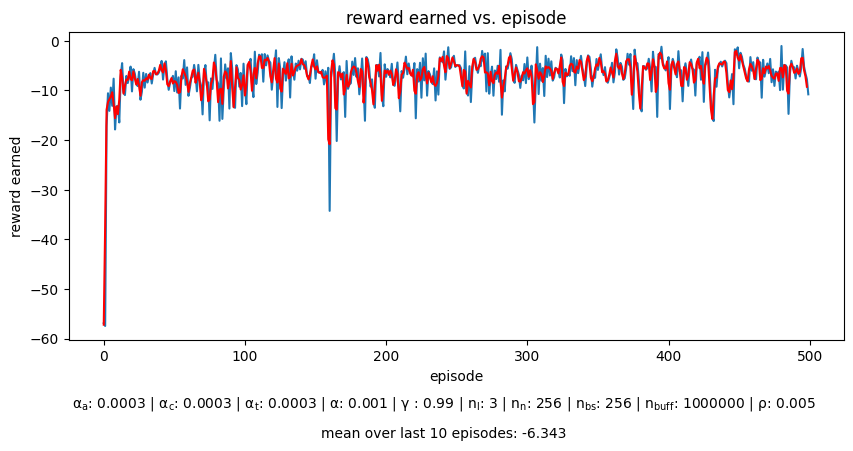

In [9]:
# moving average function:
def moving_average(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'valid')

filtered_data = moving_average(reward_history, 2)
last_few = np.mean(reward_history[-over_last:]).round(3)

figure = plt.figure(figsize = (10, 4))
plt.plot(reward_history)
plt.plot(filtered_data, 'r-')
plt.minorticks_on
plt.title('reward earned vs. episode')
plt.xlabel('episode')
plt.ylabel(f'reward earned')
plt.figtext(x = 0.5, y = -0.05, s = fr"$\mathrm{{\alpha_a}}$: {lr_a} | $\mathrm{{\alpha_c}}$: {lr_c} | $\mathrm{{\alpha_t}}$: {lr_t} | $\mathrm{{\alpha}}$: {alpha} | $\mathrm{{\gamma}}$ : {gamma} | $\mathrm{{n_l}}$: {layers} | $\mathrm{{n_n}}$: {neurons} | $\mathrm{{n_{{bs}}}}$: {batch_size} | $\mathrm{{n_{{buff}}}}$: {buffer_size} | $\mathrm{{\rho}}$: {polyak_coefficient}", ha = 'center', va = 'center')
plt.figtext(x = 0.5, y = -0.125, s = fr"mean over last {over_last} episodes: {last_few}", ha = 'center', va = 'center')

# save figure:
if len(model_path) != 0:
    try:
        plt.savefig(f"{model_path}/reward_episode_plot.png", bbox_inches = 'tight')
    except Exception as e:
        print(f"could not save: {e}")

In [ ]:
visualize = True
width = 1280
height = 1280

if visualize:
    match env_name:
        case "InvertedDoublePendulum-v5":
            default_camera_config = {"azimuth" : 90.0, "elevation" : 0.0, "distance" : 3.5, "lookat" : [0.0, 0.0, 0.25]}
            env = gym.make(env_name,
                        healthy_reward = 10.0,
                        render_mode = "human", 
                        width = width,
                        height = height,
                        default_camera_config = default_camera_config)
        case "Reacher-v5":
            default_camera_config = {"azimuth" : 90.0, "elevation" : -90.0, "distance" : 1.5, "lookat" : [0.0, 0.0, 0.25]}
            env = gym.make(env_name,
                           render_mode = "human",
                           reward_dist_weight = 1.0,
                           width = width, 
                           height = height,
                           default_camera_config = default_camera_config, 
                           max_episode_steps = 50)  

    agent.env = env
    obs, _ = agent.env.reset()
    done = False
    
    while not done:
        # 0) RENDER:
        agent.env.render()

        # 1) SAMPLE A RANDOM ACTION:
        obs_norm = agent.normalizer.normalize(obs)
        obs_norm_tensor = tf.convert_to_tensor([obs_norm], dtype = tf.float32)

        mean, log_std = agent.actor(obs_norm_tensor)                    # get network output
        log_std = tf.clip_by_value(log_std, -20, 1)                     # clamp the log-std to prevent huge/small stds
        std = tf.exp(log_std)                                           # convert from log_std to std
        z = tf.random.normal(shape = tf.shape(mean))                    # sample the standard normal distribution
        pre_tanh = mean + std*z                                         # use location-scaling to go from N(0,1) to N(μ, σ^2)

        # squash action using tanh, scale action into action bounds:
        scaled_action = tf.tanh(pre_tanh)[0] * np.array(agent.action_scale, dtype = np.float32)

        # add noise:
        scaled_action += tf.random.normal(shape = scaled_action.shape, dtype = scaled_action.dtype, stddev = 0.0)

        # 2) DO ACTION:
        next_obs, reward, term, trunc, _ = agent.env.step(scaled_action.numpy().astype(np.float32))

        # 3) ADVANCE:
        obs = next_obs

        # 4) CHECK FOR COMPLETION:
        done = term or trunc
    
    agent.env.close()

Pressed ESC
Quitting.


c:\Users\mtidd2\Desktop\rl_experimentation\venv\Lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


In [ ]:
print(f"mean is: {agent.normalizer.mean}\n")
print(f"var is: {agent.normalizer.var}\n")